# Data-Set Secondary Pre-Processing

This notebook further focusses on processing steps we can use to enhance the images in our data-sets

## Author: Alexander Goudemond, Student Number: 219030365

# Imports

In [1]:
from os import remove, mkdir
from os.path import exists, join

from shutil import move # moves and replaces files

import cv2
from PIL.Image import fromarray

import numpy as np
import matplotlib.pyplot as plt

# Previous Results:

This section of the notebook summarises the notes from 004

1105, 1106, 1201 and 1202 are useful to show the user the hidden information in the images. 

0801 and 0802 are super close at being useful, however, they posses undesirable features

0805, 1101 and 1103 may be useful for segmentation

It may be worth attempting to try introduce an AND gate between 2 images, in order to extract only the common information. Though this may preserve noise... 

To get an idea of what we are hoping to achieve, let us open 2 images from one of our reference materials: Magnussen (PhD Thesis)

The images will be available in the COMP700 Proposal, if not provided by the author



Segmentation Example


![Segmentation Example](Magnusson_Segmentation_Sample.png "Segmentation Example")

Tracking Example Below:

As we can see above, in the segmentation example from Magnussen, (b) is a desirable Processing step before segmentation

At the moment, we have the following desirable affects:


Hidden Info present (1105, 1106, 1201, 1202):


![Hidden Info 1](004_InitialPreProcessing\1105_ErodedNegativeImages.png "Hidden Info 1")

![Hidden Info 2](004_InitialPreProcessing\1106_OpenedNegativeImages.png "Hidden Info 2")

![Hidden Info 3](004_InitialPreProcessing\1201_HistEq_ErodedAtEnd_BlurAdaptiveThresholdMean.png "Hidden Info 3")

![Hidden Info 4](004_InitialPreProcessing\1202_HistE1_OpenedAtStart_BlurAdaptiveThresholdMean.png "Hidden Info 4")

Almost pleasant processed Images (0801, 0802):

![Almost Pleasant Processed Images 1](004_InitialPreProcessing\0801_OtsuThreshold.png "Almost Pleasant Processed Images 1")

![Almost Pleasant Processed Images 2](004_InitialPreProcessing\0802_Blur_OtsuThreshold.png "Almost Pleasant Processed Images 2")


Potential Useful Images (0805, 1101, 1103):


![Potentially Useful Images 1](004_InitialPreProcessing\0805_BlurAdaptiveThresholdMean.png "Potentially Useful Images 1")

![Potentially Useful Images 2](004_InitialPreProcessing\1101_ErodedImages.png "Potentially Useful Images 2")

![Potentially Useful Images 3](004_InitialPreProcessing\1103_OpenedImages.png "Potentially Useful Images 3")

As we can see from the 3 pictures above, The processing we are attempting to produce is not of the same quality of Magnussen YET

One of the challenges we are facing is to find a processing step that assists all 10 data-sets, because if we only focussed on 1 data-set we would be able to pick a specific processing option... 

For ease of reference, bottom left of the images above corresponds to Magnussen:

![Segmentation Example](Magnusson_Segmentation_Sample.png "Segmentation Example")

From the above images, we can visualy see that 1103 is the closest to improving things, but it is rather dark. We need to try use this technique to brighten the overall image, so that we can move forward. The other techniques tried in 004 may be unhelpful as they either help a few data-sets and damage others, or introduce noise...

We will carefully explore the combinations here, though

Infact, upon closer inspection, 1105 and 1106 may be useful after all... Let us carefully compare and contrast 1101, 1103, 1105, 1106

![1101](004_InitialPreProcessing\1101_ErodedImages.png "1101")

![1103](004_InitialPreProcessing\1103_OpenedImages.png "1103")

![1105](004_InitialPreProcessing\1105_ErodedNegativeImages.png "1105")

![1106](004_InitialPreProcessing\1106_OpenedNegativeImages.png "1106")

Between 1101 and 1103, 1103 is better!

Between 1105 and 1106, 1106 appears better!

Let us carefully consider 1103 vs 1106

![1103](004_InitialPreProcessing\1103_OpenedImages.png "1103")

![1106](004_InitialPreProcessing\1106_OpenedNegativeImages.png "1106")

Both 1103 and 1106 contain useful information! We should create videos from them, to cover whether the results are universally good. We are also interested in whether these formatting tools assist with the test cases

Of course they are both good! One is an opened image, the other is the negative of it!

So instead, let us create a video using the technique from 1106 as well as a video from 0805 to see if our results are helpful

#  1106 and 0805 Videos

This section of the notebook focusses on videos using the techniques present in 0805 and 1106, identified in the notebook 004

This section will closely follow the system developed in 003:

- We need a variable containing the Directory Names

- We need to generate a collection of locations from each of those Directories, for each data-set

- We need a variable containing the Image Sizes

- We need 4 functions: processImage x 2, generateVideo, moveVideo

- Thereafter, we can create small sample videos and save them here, for ease of reference

Directories:

In [2]:
from os import getcwd, walk

data_sets = "..\\..\\Comp700_DataSets"
current_directory = getcwd()

path = walk(current_directory + "\\" + data_sets)

directory_array = [] # contains the main folders

i = 1
for root, dirs, files in path:
    if (i == 2):
        directory_array = dirs
        break
    
    i += 1

print("Directory Array")
print(directory_array)

Directory Array
['BF-C2DL-HSC', 'BF-C2DL-HSC (1)', 'BF-C2DL-MuSC', 'BF-C2DL-MuSC (1)', 'DIC-C2DH-HeLa', 'DIC-C2DH-HeLa (1)', 'Fluo-C2DL-Huh7', 'Fluo-C2DL-Huh7 (1)', 'Fluo-C2DL-MSC', 'Fluo-C2DL-MSC (1)', 'Fluo-N2DH-GOWT1', 'Fluo-N2DH-GOWT1 (1)', 'Fluo-N2DH-SIM+', 'Fluo-N2DH-SIM+ (1)', 'Fluo-N2DL-HeLa', 'Fluo-N2DL-HeLa (1)', 'PhC-C2DH-U373', 'PhC-C2DH-U373 (1)', 'PhC-C2DL-PSC', 'PhC-C2DL-PSC (1)']


Locations:

In [3]:
# First, generate a list of the locations for each folder of Petri Dish images

path = walk(current_directory + "\\" + data_sets) # reset path

location_array = []

# used to cycle between 2 folders, present in each directory
sub_directory_choice = ["\\01\\", "\\02\\"]

i = 0 # will grow from 0 to 39
index = 0 # we need to lie in [0, 19]
for root, dirs, files in path:
    # print(dirs)
    for item in files:
        if ("t0000.tif" == item) or ("t000.tif" == item):
            index = i // 2

            location = ( current_directory + "\\" + data_sets + "\\Extracted\\" + directory_array[index] + 
                        "\\" + directory_array[index] + sub_directory_choice[i % 2])
            
            i += 1
            # print(location)
            location_array.append(location)

print(location_array)



['c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-HSC\\BF-C2DL-HSC\\01\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-HSC\\BF-C2DL-HSC\\02\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-HSC (1)\\BF-C2DL-HSC (1)\\01\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-HSC (1)\\BF-C2DL-HSC (1)\\02\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-MuSC\\BF-C2DL-MuSC\\01\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-MuSC\\BF-C2DL-MuSC\\02\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-MuSC (1)\\BF-C2DL-MuSC (1)\\01\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_DataSets\\Extracted\\BF-C2DL-MuSC (1)\\BF-C2DL-MuSC (1)\\02\\', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\

Image Sizes:

We only need to scan the dimensions of the first image as all images in a folder contain the same dimensions!

In [4]:
import cv2

image_size_array = []

path = walk(current_directory + "\\" + data_sets) # reset path

i = -1 # will grow from 0 to 39
for root, dirs, files in path:
    for item in files:
        if ("man_" not in item) and (".zip" not in item):
            # update on first element only
            if ("t0000.tif" == item) or ("t000.tif" == item):  
                i += 1

            img = cv2.imread( (location_array[i] + item), cv2.IMREAD_GRAYSCALE)
            (x, y) = img.shape

            image_size_array.append([x, y])
            break
            

        # skip "man_" images
        else:
            break

print(image_size_array)


[[1010, 1010], [1010, 1010], [1010, 1010], [1010, 1010], [1036, 1070], [1036, 1070], [1036, 1070], [1036, 1070], [512, 512], [512, 512], [512, 512], [512, 512], [1024, 1024], [1024, 1024], [1024, 1024], [1024, 1024], [832, 992], [782, 1200], [832, 992], [782, 1200], [1024, 1024], [1024, 1024], [1024, 1024], [1024, 1024], [690, 628], [773, 739], [718, 660], [790, 664], [700, 1100], [700, 1100], [700, 1100], [700, 1100], [520, 696], [520, 696], [520, 696], [520, 696], [576, 720], [576, 720], [576, 720], [576, 720]]


Kernel for Morphological Process

In [5]:
kernel = np.ones((3,3), np.uint8)

Useful Functions:

In [6]:
# create directory for work we create
def tryMakeDirectory(current_directory, destination_directory):
    try:
        # join comes from os.path
        mkdir( join(current_directory, destination_directory) )
    except FileExistsError:
        print("Folder already exists!")
        pass
    except:
        print("Unknown Error Encountered...")
###

def openImage(image):
    img_erode = cv2.erode(image, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)

    max_val = np.amax(img_opened)
    neg_img = max_val - img_opened

    return neg_img
###

def blurredAdaptiveThreshold(image):
    max_value = np.amax(image)

    blur = cv2.GaussianBlur(image, (5, 5), 0)
    thresh_img = cv2.adaptiveThreshold(blur, max_value, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=11, C=2)

    return thresh_img
###

# processingChoice == 1 or 2
def generateVideos(current_directory, desired_folder, processingChoice):
    # only progress if files don't exist
    makeVideos = False

    if (exists(current_directory + "\\" + desired_folder)):
        # Now, go to directory and verify all is there
        path = walk(current_directory + "\\" + desired_folder)

        count = 0
        for root, dirs, files in path:
            for item in files:
                count += 1

        if (count == 40):
            print("All Videos exist already!")
        else:
            print("Not all Videos exist")
            makeVideos = True
    else:
        makeVideos = True
        
    if (makeVideos):
        path = walk(current_directory + "\\" + data_sets) # reset path

        sub_directory_choice = ["01", "02"]

        i = -1
        output_video = cv2.VideoWriter()
        frames_per_second = 10
        petri_dish_images = False

        # Generates Colour Videos
        for root, dirs, files in path:
            for item in files:
                if ("man_" not in item) and (".zip" not in item):
                    # update on first element only
                    if ("t0000.tif" == item) or ("t000.tif" == item):  

                        if (processingChoice == 1):
                            fileName = "blurredAdaptiveThreshold"
                        else:
                            fileName = "Opened"

                        petri_dish_images = True
                        i += 1
                        index = i // 2 # used for output video as 2 copies for each directory

                        size = (image_size_array[i][1], image_size_array[i][0] ) # notice order
                        fileName += "_" + directory_array[index] + "_" + sub_directory_choice[i % 2] + ".mp4"
                        
                        output_video = cv2.VideoWriter(
                            fileName, 
                            cv2.VideoWriter_fourcc(*'DIVX'), 
                            frames_per_second, 
                            size,
                            isColor=False # either True or False
                        )

                    img = plt.imread( location_array[i] + item) 
                    plt.imsave("temp.jpg", img, cmap="gray") # desired colourmap for us
                    img = cv2.imread( "temp.jpg", cv2.IMREAD_GRAYSCALE)

                    if (processingChoice == 1):
                        new_img = blurredAdaptiveThreshold(img)
                    else:
                        new_img = openImage(img)
                        
                    output_video.write(new_img)

                else:
                    petri_dish_images = False
                    break
                    

            if (petri_dish_images):     
                cv2.destroyAllWindows()
                output_video.release()
                print("Video finished for ", fileName, sep="")
                petri_dish_images = False # update incase next iteration containes empty array
    
    # remove at end
    if (exists("temp.jpg")):
        remove("temp.jpg")
###

def moveBulkVideos(current_directory, desired_folder):
    # only progress if files don't exist
    if (exists(current_directory + "\\" + desired_folder)):
        print("Videos already exist!")
    else:
        # local function
        tryMakeDirectory(current_directory, desired_folder)

        path = walk(current_directory)

        for root, dirs, files in path:
            for item in files:
                if (".mp4" in item):
                    new_destination = current_directory + "\\" + desired_folder
                    move(join(current_directory, item), join(new_destination, item)) # should overwrite existing data

        # Now, go to directory and verify all is there
        path = walk(current_directory + "\\" + desired_folder)

        count = 0
        for root, dirs, files in path:
            for item in files:
                count += 1

        if (count == 40):
            print("All Videos Moved Successfully!")
        else:
            print("Not all Videos Moves Successfully")
###

In [7]:
generateVideos(current_directory, "..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold", 1)

All Videos exist already!


In [8]:
moveBulkVideos(current_directory, "..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold")

Videos already exist!


Those videos were generated successfully, however they have an incredible amount of noise and further processing may disrupt the cell borders. We will create small snippets of those videos to show the reader soon


Let us next focus on generating the Opened Videos:

In [9]:
generateVideos(current_directory, "..\\..\\Comp700_VideosOfDataSets_Opened", 2)

All Videos exist already!


In [10]:
moveBulkVideos(current_directory, "..\\..\\Comp700_VideosOfDataSets_Opened")

Videos already exist!


# Video Snippets

This section of the notebook looks at snippets of 3 videos and placing them together to better understand the change in form

What we seek to do is create snippets of the videos from: Seismic, BlurAdaptiveMean and Opened and compare them for 10 data-sets (Just the 01 folder)

In [11]:
from moviepy.editor import *
from IPython.display import Video

First, we need to generate a variable with the locations of each video

In [12]:
# from os import getcwd, walk

desired_directory = getcwd() + "\\..\\.."
# print(desired_directory)

path = walk(desired_directory)

directories = []

# extract first directory list
for root, dirs, files in path:
    directories = dirs
    break

# print(directories)

# Extract 4 folders of videos

video_directories = []

for item in directories:
    if ("Comp700_Videos" in item):
        video_directories.append(item)

print(video_directories)

['Comp700_VideosOfDataSets_BlurAdaptiveThreshold', 'Comp700_VideosOfDataSets_Colour', 'Comp700_VideosOfDataSets_Grayscale', 'Comp700_VideosOfDataSets_Greys', 'Comp700_VideosOfDataSets_Opened', 'Comp700_VideosOfDataSets_Seismic']


We seek to stitch Seismic, BlurAdaptiveThreshold and Opened images together

Let us generate the specific locations to each:

In [13]:

a, b, c, d, e, f = [], [], [], [], [], []

# This will be used to read the videos side by side
location_collection = [a, b, c, d, e, f]

starting_point = ""
for i in range(len(video_directories)):
    starting_point = desired_directory + "\\" + video_directories[i]
    # print(starting_point)

    path = walk(starting_point)

    for root, dirs, files in path:
        for name in files:
            # only sample 1 of each folder
            if ("(1)" not in name) and ("_01" in name):
                # print(name)
                location_collection[i].append(starting_point + "\\" + name)

# print(location_collection)

In [14]:
print(location_collection)

[['c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_BF-C2DL-HSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_BF-C2DL-MuSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_DIC-C2DH-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-C2DL-Huh7_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-C2DL-MSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-N2DH-GOWT1_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAda

location_collection contains 10 videos for 6 folders. We only desire 3 of those folders:

In [15]:
# order matters
blurAdaptive_video_location, opened_video_loction, seismic_video_location  = [], [], []
cluster_locations = [blurAdaptive_video_location, opened_video_loction, seismic_video_location]

keyWords = ["BlurAdaptiveThreshold", "Opened", "Seismic"]

for i in range(len(video_directories)):
    # print(video_directories[i])

    if (keyWords[0] in video_directories[i]):
        cluster_locations[0] = location_collection[i] 
    elif (keyWords[1] in video_directories[i]):
        cluster_locations[1] = location_collection[i] 
    elif (keyWords[2] in video_directories[i]):
        cluster_locations[2] = location_collection[i] 

In [16]:
print(cluster_locations[0])

['c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_BF-C2DL-HSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_BF-C2DL-MuSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_DIC-C2DH-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-C2DL-Huh7_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-C2DL-MSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdaptiveThreshold_Fluo-N2DH-GOWT1_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_BlurAdaptiveThreshold\\blurredAdap

In [17]:
print(cluster_locations[1])

['c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_BF-C2DL-HSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_BF-C2DL-MuSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_DIC-C2DH-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_Fluo-C2DL-Huh7_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_Fluo-C2DL-MSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_Fluo-N2DH-GOWT1_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_Fluo-N2DH-SIM+_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Opened\\Opened_Fluo-N2DL-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_

In [18]:
print(cluster_locations[2])

['c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_BF-C2DL-HSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_BF-C2DL-MuSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_DIC-C2DH-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_Fluo-C2DL-Huh7_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_Fluo-C2DL-MSC_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_Fluo-N2DH-GOWT1_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_Fluo-N2DH-SIM+_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_VideosOfDataSets_Seismic\\seismic_Fluo-N2DL-HeLa_01.mp4', 'c:\\Users\\G5\\Documents\\GitHub\\COMP700\\..\\..\\Comp700_V

Great! We now have a detailed list of locations for blurAdaptive_video_location, opened_video_loction, seismic_video_location

Let us make a directory for the videos:

In [19]:
desired_directory = "005_SecondaryPre-Processing"
tryMakeDirectory(current_directory, desired_directory)

Folder already exists!


The algorithm for the next step is:

- Generate a small slice of the video (we will do this 3 times)

- stitch the 3 videos together

- write them to our desired_directory

First, generate the the file names to use:

In [20]:
names_to_use = []

for item in location_collection[0]:
    position = item.rindex("\\")

    # extracted name
    name = item[ position + 1 : ]
    # print(name)

    #remove "Color at front"
    position = name.index("_")
    # print(name[position + 1 : ])

    names_to_use.append("3_stitched_" + name[position + 1 : ])

print(names_to_use)

['3_stitched_BF-C2DL-HSC_01.mp4', '3_stitched_BF-C2DL-MuSC_01.mp4', '3_stitched_DIC-C2DH-HeLa_01.mp4', '3_stitched_Fluo-C2DL-Huh7_01.mp4', '3_stitched_Fluo-C2DL-MSC_01.mp4', '3_stitched_Fluo-N2DH-GOWT1_01.mp4', '3_stitched_Fluo-N2DH-SIM+_01.mp4', '3_stitched_Fluo-N2DL-HeLa_01.mp4', '3_stitched_PhC-C2DH-U373_01.mp4', '3_stitched_PhC-C2DL-PSC_01.mp4']


Now, let us stitch them together!

In [21]:
# investigate if videos already exist
path = walk(desired_directory)

count = 0
for root, dirs, files in path:
        for name in files:
            if ("01" in name):
                count += 1

# print(count)

name_array = ["vid1.mp4", "vid2.mp4", "vid3.mp4"]

if (count == 10):
    print("Videos already exist in ", desired_directory, "!", sep="")
else:
    for i in range(10):
        for j in range(3):
            clip = VideoFileClip(cluster_locations[j][i])

            # getting only first 5 seconds
            clip = clip.subclip(0, 5)

            # new clip with new duration
            new_clip = clip.set_duration(5)

            # reduce by 75%
            resized_clip = new_clip.resize(0.25)

            resized_clip.write_videofile(name_array[j])    

        # at this point, read in the 4 videos
        a = VideoFileClip(name_array[0])
        b = VideoFileClip(name_array[1])
        c = VideoFileClip(name_array[2])

        # now, stitch together!
        stitched_video = clips_array([[a, b, c]])
        stitched_video.write_videofile(desired_directory + "\\" + names_to_use[i])
        
        resized_clip.close()
        a.close(); b.close(); c.close()
        stitched_video.close()
    

Videos already exist in 005_SecondaryPre-Processing!


In [22]:
# at end, remove 4 videos:
for i in range(3):
    if (exists(name_array[i])):
        remove(name_array[i])

Let us look at those video samples:

In [23]:
# returns video object, which embeds in notebook
def showVideoClip(directory, videoNumber):
    # access outside function
    global names_to_use 

    print(names_to_use[videoNumber])
    vid = Video(directory + "\\" + names_to_use[videoNumber])
    return vid

In [24]:
showVideoClip(desired_directory, 0)

3_stitched_BF-C2DL-HSC_01.mp4


In [25]:
showVideoClip(desired_directory, 1)

3_stitched_BF-C2DL-MuSC_01.mp4


In [26]:
showVideoClip(desired_directory, 2)

3_stitched_DIC-C2DH-HeLa_01.mp4


In [27]:
showVideoClip(desired_directory, 3)

3_stitched_Fluo-C2DL-Huh7_01.mp4


In [28]:
showVideoClip(desired_directory, 4)

3_stitched_Fluo-C2DL-MSC_01.mp4


In [29]:
showVideoClip(desired_directory, 5)

3_stitched_Fluo-N2DH-GOWT1_01.mp4


In [30]:
showVideoClip(desired_directory, 6)

3_stitched_Fluo-N2DH-SIM+_01.mp4


In [31]:
showVideoClip(desired_directory, 7)

3_stitched_Fluo-N2DL-HeLa_01.mp4


In [32]:
showVideoClip(desired_directory, 8)

3_stitched_PhC-C2DH-U373_01.mp4


In [33]:
showVideoClip(desired_directory, 9)

3_stitched_PhC-C2DL-PSC_01.mp4


Great! What do we notice from the 10 videos above?

- Fluo-C2DL-Huh7 has a very small number of images, so the video appears frozen after 2 seconds due to the lack of images

- The Blurred Adaptive Threshold would be lovely, but there is noticeably bad noise in Fluo-C2DL-MSC and DIC-C2DH-HeLa

- DIC-C2DH-HeLa loses the cell boundary in Blurred Adaptive Threshold, which is a big downside! This may well be one of our most challenging data-sets

- Additional smoothing of Blurred Adaptive Threshold could remove additional features and cell boundaries, so Opening may be best...

- All 3 videos capture the inconsistent lighting. Processing won't be able to remove this

- BF-C2DL-MuSC has some kind of consistent 'rivers' present, across frames, that we did not identify in the seismic video... Upon close inspection, the original videos do show a slight 'slime trail' or 'river', but the thresholding brings it out clearly. Hopefully segmentation of this data-set will not reveal those trails

- PhC-C2DL-PSC has some fast moving particles, clearly present in the Blurred Adaptive Threshold, but NOT present in the Opened Image. This may assist us later on with tracking!

- PhC-C2DL-PSC is also too well lit...

# Next Steps and Conclusions

This section of the notebook considers the final options for processing of the Images

The Opened Images are the best kind of processing we can find. Let us consider 1 final batch of processing upon the opened Images, to see if we can improve things any further

Recall that the best performing processing so far is 1103. 1106 is simply the negative of this, and more clearly shows the features to a human eye. 1103 uses Morphological Opening, so we need to consider variations on it:

- Does brightening the entire Image help?

- If we open, then apply different Morphological Operations, do our results improve?

To complete the processing steps, we will bring the functions created in 004 here and work from there:

In [34]:
# from PIL.Image import fromarray

def stitchTogetherPics(array_of_images):
    # top level
    myList = (array_of_images[0], array_of_images[1], array_of_images[2], array_of_images[3], array_of_images[4])
    numpy_horizontal_top = np.hstack(myList)

    # bottom level
    myList = (array_of_images[5], array_of_images[6], array_of_images[7], array_of_images[8], array_of_images[9])
    numpy_horizontal_bottom = np.hstack(myList)

    # stick 2 ontop of one another
    myList = (numpy_horizontal_top, numpy_horizontal_bottom)
    numpy_final_pic_concat = np.concatenate(myList, axis=0)

    return numpy_final_pic_concat
###

# save and show in cell
def saveAndShow(desired_directory, image_array, picName):
    fileName = desired_directory + "\\" + picName

    # Save pic to file, using Pillow!
    new_img = fromarray(stitchTogetherPics(image_array))
    new_img.save(fileName) # save using Pillow

    width = 30
    height = 10
    fig = plt.figure()
    fig.set_figwidth(width); fig.set_figheight(height)

    new_img = plt.imread(fileName)
    plt.title(picName)
    plt.axis('off')
    plt.imshow(new_img, cmap='gray')
###

Let us create the object with our images:

In [35]:
initial_directory = "004_InitialPreProcessing"

In [36]:
path = walk(initial_directory)

test_images = [] # reset variable
test_images_names = []

for root, dirs, files in path:
    for pic_name in files:
        if (".tiff" in pic_name):
            # print(pic_name)
            test_images_names.append(pic_name)
# print(test_images_names)

# read in images in 1 go
for i in range(len(test_images_names)):
    if (i == 0):
        (x, y) = img.shape
        x = x // 2
        y = y // 2
        
    img = cv2.imread(initial_directory + "\\" + test_images_names[i], cv2.IMREAD_GRAYSCALE)
    img_reshaped = cv2.resize(img, (x, y))
    test_images.append(img_reshaped)

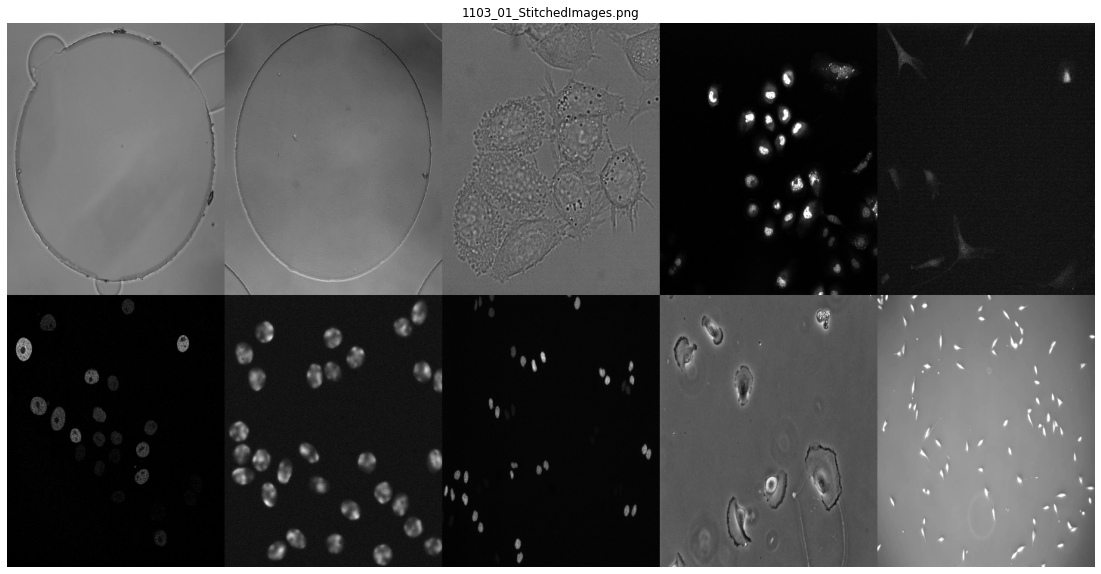

In [37]:
desired_directory = "005_SecondaryPre-Processing"
picName = "1103_01_StitchedImages.png"
saveAndShow(desired_directory, test_images, picName)

Great! Let us recreate the processing for the Opened Images and save it to verify all is working

In [38]:
kernel = np.ones((3,3), np.uint8)

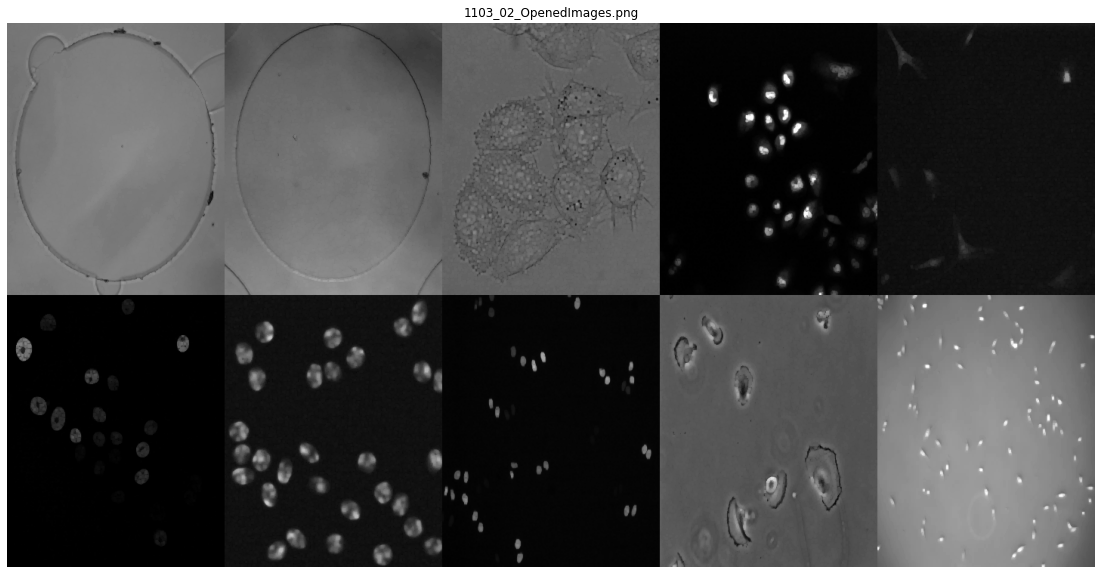

In [39]:
# Opening

image_collection = []

for i in range(len(test_images)):
    img_erode = cv2.erode(test_images[i], kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)
    
    image_collection.append(img_opened)

picName = "1103_02_OpenedImages.png"
saveAndShow(desired_directory, image_collection, picName)

Attempt Brightening:

In [50]:
# Function adapted from author: Bill grates, Nov 22, 2017 at 5:26
def increase_brightness(img, value=30):
    newImg = img.copy()

    maxVal = np.amax(newImg)
    lim = maxVal - value

    # do not increase largest values
    newImg[newImg > lim] = 255

    # increase rest
    newImg[newImg <= lim] += value

    # do not increase lowest values
    # minVal = np.amin(i)
    # newImg[newImg == minVal + value] = minVal

    # attempt to keep smallest values at minVal
    # minVal = np.amin(i)
    # lim = minVal + value
    # newImg[newImg <= lim] = minVal
    
    return newImg
###

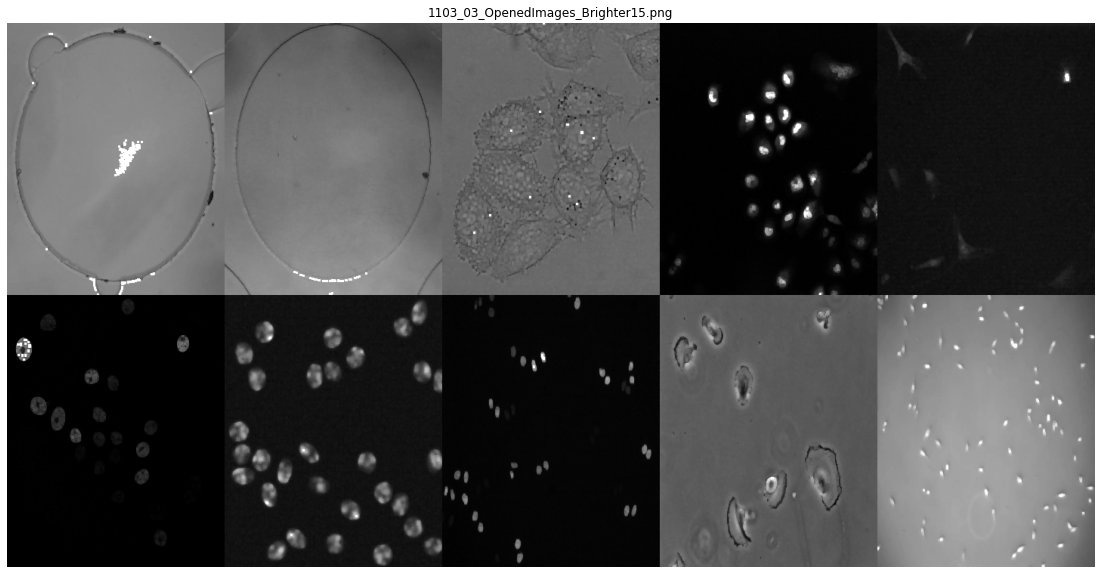

In [51]:
# Opening and brighten by 15 intensity values

image_collection = []

for i in range(len(test_images)):
    img_erode = cv2.erode(test_images[i], kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)

    brighter_img = increase_brightness(img_opened, 15)
    
    image_collection.append(brighter_img)

picName = "1103_03_OpenedImages_Brighter15.png"
saveAndShow(desired_directory, image_collection, picName)

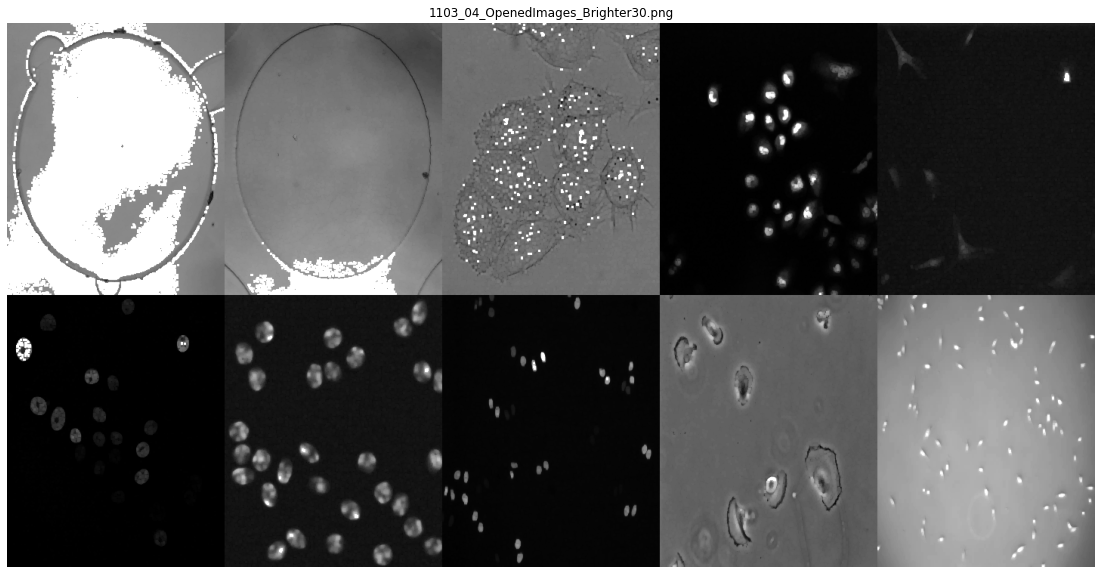

In [52]:
# Opening and brighten by 30 intensity values

image_collection = []

for i in range(len(test_images)):
    img_erode = cv2.erode(test_images[i], kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)

    brighter_img = increase_brightness(img_opened, 30)
    
    image_collection.append(brighter_img)

picName = "1103_04_OpenedImages_Brighter30.png"
saveAndShow(desired_directory, image_collection, picName)

Brightening AFTER the Image is opened may be affecting the first 3 data-sets. Let us try brightening first:

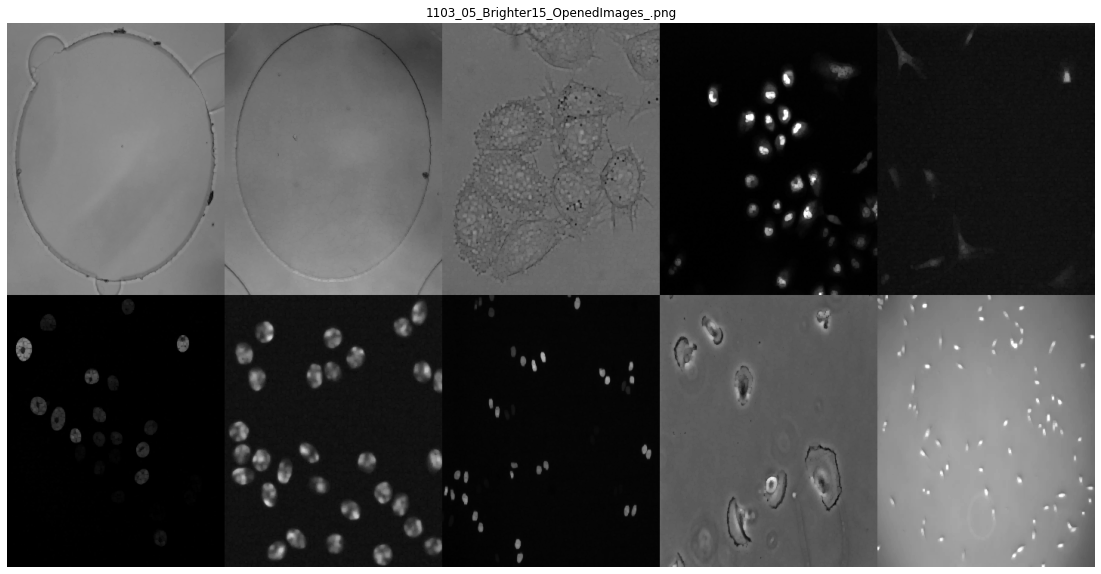

In [53]:
# Opening and brighten by 15 intensity values

image_collection = []

for i in range(len(test_images)):

    brighter_img = increase_brightness(test_images[i], 15)

    img_erode = cv2.erode(brighter_img, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)
    
    image_collection.append(img_opened)

picName = "1103_05_Brighter15_OpenedImages_.png"
saveAndShow(desired_directory, image_collection, picName)

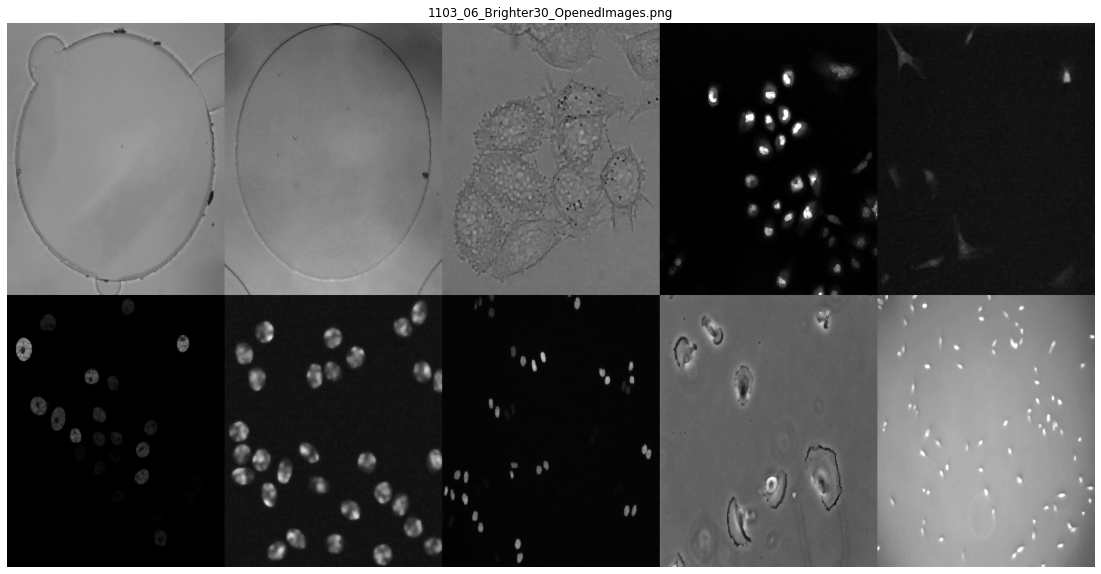

In [54]:
# Opening and brighten by 30 intensity values

image_collection = []

for i in range(len(test_images)):

    brighter_img = increase_brightness(test_images[i], 30)

    img_erode = cv2.erode(brighter_img, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)
    
    image_collection.append(img_opened)

picName = "1103_06_Brighter30_OpenedImages.png"
saveAndShow(desired_directory, image_collection, picName)

Brightening by 15 before Opening appears to be a nice processing step. Next, let us consider opening twice:

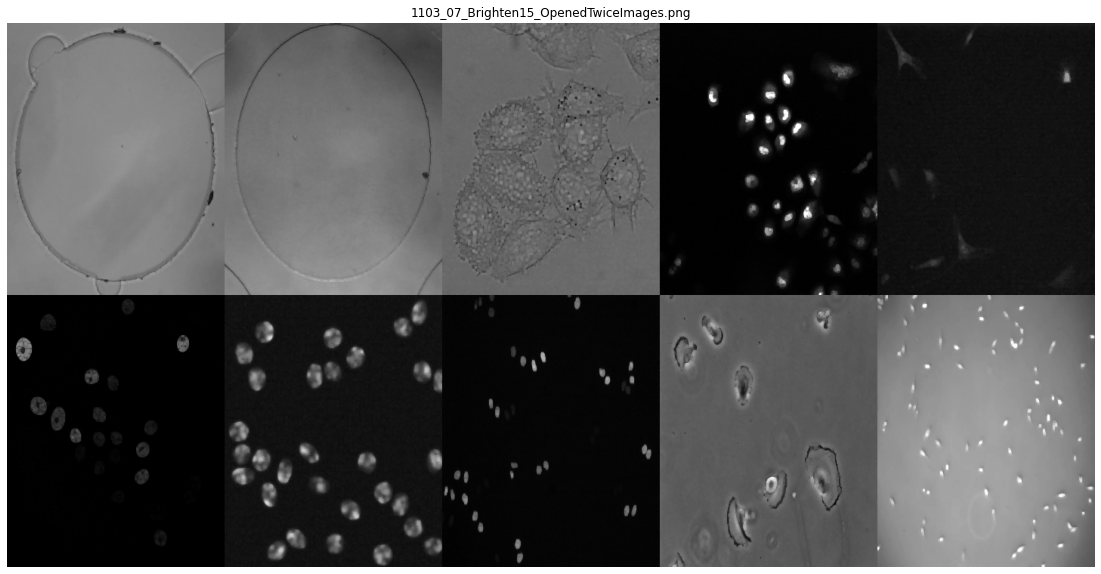

In [59]:
# Opening twice and Brighter by 15

image_collection = []

for i in range(len(test_images)):
    image = test_images[i]

    brighter_img = increase_brightness(image, 15)

    img_erode = cv2.erode(brighter_img, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)

    image = img_opened

    img_erode = cv2.erode(image, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=1)
    
    image_collection.append(img_opened)

picName = "1103_07_Brighten15_OpenedTwiceImages.png"
saveAndShow(desired_directory, image_collection, picName)

Opening twice does not appear to make a difference.. What about changing the iterations?

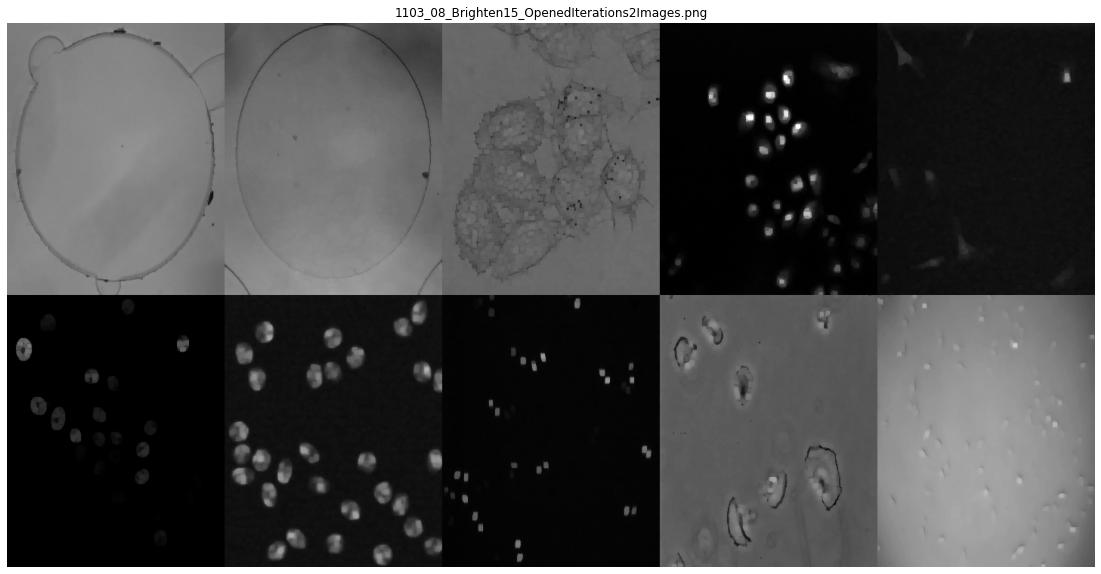

In [60]:
# Opening twice and Brighter by 15

image_collection = []

for i in range(len(test_images)):
    image = test_images[i]

    brighter_img = increase_brightness(image, 15)

    img_erode = cv2.erode(brighter_img, kernel, iterations=2)
    img_opened = cv2.dilate(img_erode, kernel, iterations=2)
    
    image_collection.append(img_opened)

picName = "1103_08_Brighten15_OpenedIterations2Images.png"
saveAndShow(desired_directory, image_collection, picName)

Nope! 2 iterations only make it worse... What about 2 iterations on dilation only?

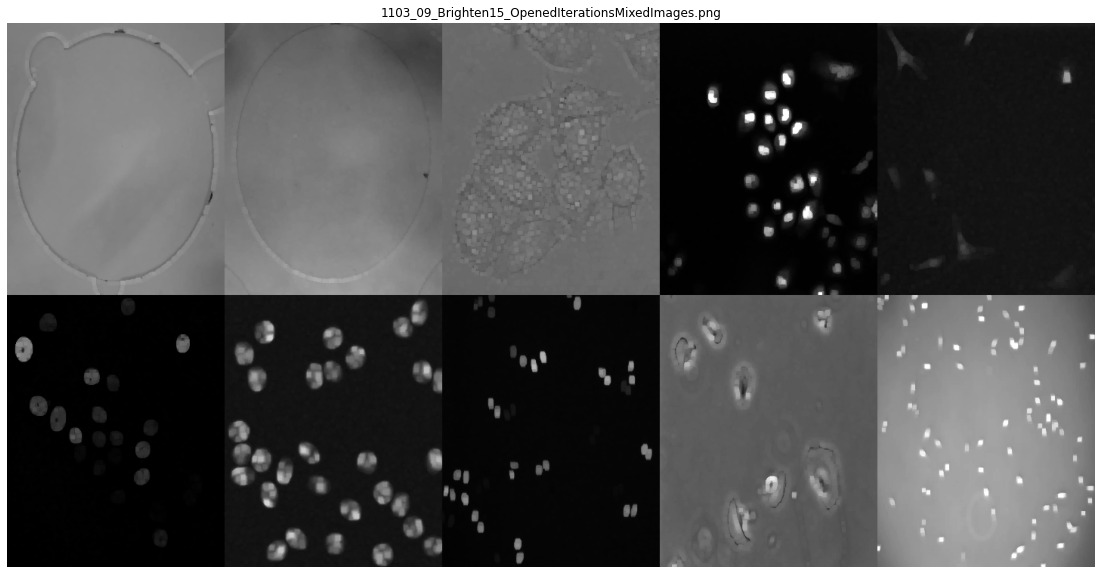

In [61]:
# Opening twice and Brighter by 15

image_collection = []

for i in range(len(test_images)):
    image = test_images[i]

    brighter_img = increase_brightness(image, 15)

    img_erode = cv2.erode(brighter_img, kernel, iterations=1)
    img_opened = cv2.dilate(img_erode, kernel, iterations=2)
    
    image_collection.append(img_opened)

picName = "1103_09_Brighten15_OpenedIterationsMixedImages.png"
saveAndShow(desired_directory, image_collection, picName)

It is still too blurry... 1 Iteration is sufficient.

Next, let us consider Opening followed by other Morphological Operations